## General LSTM Model

This model use multiple features: price, trading volume, and TVL to predict coin prices

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.0 MB/s eta 0:00:00


In [2]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import shap

Instructions for updating:
non-resource variables are not supported in the long term


### Import the data

In [3]:
# Read the data based on coin
def read_data(coin):
    # Read csv
    df = pd.read_csv("data/" + coin + ".csv")

    # Covert to datetime
    df["Date"] = pd.to_datetime(df["Date"])
    return df

### Prepare data

In [4]:
def train_test_val(df, date_train, date_validation, features):
    # Split data into training, validation and test sets
    training_data = df[(df['Date'] <= date_train)][features]
    validation_data = df[(df['Date'] > date_train) & (df['Date'] <= date_validation)][features]
    test_data = df[(df['Date'] > date_validation)][features]

    print(training_data.head())

    # Reshape the data
    training_set = training_data.to_numpy()
    validation_set = validation_data.to_numpy()
    test_set = test_data.to_numpy()
    return training_set, validation_set, test_set

### Scale the features

In [5]:
def scale_features(scaler, training_set, validation_set, test_set):
    training_set_scaled = scaler.fit_transform(training_set)
    validation_set_scaled = scaler.transform(validation_set)
    test_set_scaled = scaler.transform(test_set)
    return training_set_scaled, validation_set_scaled, test_set_scaled

### Create Input sequences

In [6]:
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i,:])
        y.append(data[i,0])
    return np.array(X), np.array(y)

### Define the model

In [7]:
def define_model(optimizer, loss, seq_length=60, num_parameters=1):
    # Define the structure
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(seq_length, num_parameters)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(units=50, return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(units=50, return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(units=50))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units=1))

    # Specify the parameters for the LSTM Model
    model.compile(optimizer=optimizer, loss=loss, metrics=[keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError()])
    return model

### Train the model

In [8]:
def train_model(model, X_train, y_train, X_validation, y_validation, epochs=100):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_validation, y_validation))
    return history

### Visualise the loss during training

In [9]:
def visualize_loss(history):
    # Plot loss during training
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Test the model

In [10]:
def test_model(model, data, X_test, y_test):
    history = model.evaluate(X_test, y_test)
    predicted_price = model.predict(X_test)

    # Fit scaler for the stock price
    feature_scaler = MinMaxScaler()
    feature_scaler.fit(data[:, 0].reshape(-1, 1))

    # Inverse transform the stock price
    predicted_price = feature_scaler.inverse_transform(predicted_price)
    return predicted_price, history

### Visualise results

In [53]:
def visualize_results(df, predicted_price, date_validation, coin, seq_length=60):
    date_range = pd.date_range(start='2024-01-01', periods=len(predicted_price), freq='B')
    test_prices = df[(df['Date'] > date_validation)]['Adj Close']
    test_dates = df[(df['Date'] > date_validation)]["Date"]
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, test_prices, color='black', label=(coin + ' Price'))
    plt.plot(test_dates[seq_length:], predicted_price, color='green', label='Predicted ' + coin + ' Price')
    plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=3))  # Show tick marks for every 3 months
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
    plt.title(coin + ' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(coin + 'Price')
    plt.legend()
    plt.show()

## Make a custom run

In [146]:
# Define the parameters
coin = "BTC"
date_train = "2023-05-01"
date_validation = "2023-11-01"
features = ["Adj Close", "sentiment_score", "normalized_influence_robust", "Volume"]
optimizer = "adam"
loss = "mean_squared_error"
seq_length = 40
epochs_train = 60

In [147]:
# Read the data
df = read_data(coin)

In [148]:
# Split the data
train, validation, test = train_test_val(df, date_train, date_validation, features)
print(train.shape)
print(validation.shape)
print(test.shape)

     Adj Close  sentiment_score  normalized_influence_robust        Volume
0  7200.174316         0.548312                     3.988636  1.856566e+10
1  6985.470215         0.497812                     1.284091  2.080208e+10
2  7344.884277         0.125570                     2.972727  2.811148e+10
3  7410.656738         0.650860                     0.463636  1.844427e+10
4  7411.317383         0.357350                    -0.045455  1.972507e+10
(1217, 4)
(184, 4)
(181, 4)


In [149]:
# Define the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
summary_train = pd.DataFrame(train)
summary_train.describe()

,0,1,2,3
count,1217.000000,1217.000000,1217.000000,1.217000e+03
mean,28453.571806,0.395079,1.834088,3.539989e+10
std,16342.025092,0.173850,1.640734,1.861389e+10
min,4970.788086,-0.210671,-0.227273,7.714767e+09
25%,13654.218750,0.247256,0.738636,2.434200e+10
50%,23656.207030,0.423686,1.446828,3.193032e+10
75%,41557.902340,0.524812,2.550944,4.206840e+10
max,67566.828130,0.975100,20.021724,3.509680e+11


In [150]:
# Scale the features
train_scaled, validation_scaled, test_scaled = scale_features(scaler, train, validation, test)
summary_train_scaled = pd.DataFrame(train_scaled)
summary_train_scaled.describe()

,0,1,2,3
count,1217.000000,1217.000000,1217.000000,1217.000000
mean,0.375148,0.510849,0.101801,0.080655
std,0.261071,0.146614,0.081028,0.054228
min,0.000000,0.000000,0.000000,0.000000
25%,0.138722,0.386186,0.047702,0.048440
50%,0.298508,0.534975,0.082676,0.070547
75%,0.584496,0.620258,0.137203,0.100082
max,1.000000,1.000000,1.000000,1.000000


In [151]:
# Create sequences for LSTM
X_train, y_train = create_sequences(train_scaled, seq_length=seq_length)
X_validation, y_validation = create_sequences(validation_scaled, seq_length=seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length=seq_length)
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(1177, 40, 4) (1177,)
(144, 40, 4) (144,)
(141, 40, 4) (141,)


In [130]:
# Reshape inputs for LSTM
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
y_validation = np.reshape(y_validation, (-1, 1))
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(827, 40, 5) (827, 1)
(96, 40, 5) (96, 1)
(97, 40, 5) (97, 1)


In [131]:
# Define the model
model = define_model(optimizer, loss, seq_length=seq_length, num_parameters=len(features))
model(tf.random.normal((1, seq_length, len(features))))

<tf.Tensor 'sequential_6/dense_6/BiasAdd:0' shape=(1, 1) dtype=float32>

In [132]:
# Train the model
history = train_model(model, X_train, y_train, X_validation, y_validation, epochs=epochs_train)

Train on 827 samples, validate on 96 samples
Epoch 1/60
827/827 [==============================] - ETA: 0s - loss: 0.0193 - mean_squared_error: 0.0193 - root_mean_squared_error: 0.1390

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


827/827 [==============================] - 4s 5ms/sample - loss: 0.0193 - mean_squared_error: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 2/60
827/827 [==============================] - 2s 2ms/sample - loss: 0.0092 - mean_squared_error: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 3/60
827/827 [==============================] - 2s 2ms/sample - loss: 0.0062 - mean_squared_error: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 4/60
827/827 [==============================] - 2s 2ms/sample - loss: 0.0062 - mean_squared_error: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 5/60
827/827 [==============================] - 2s 2ms/sample

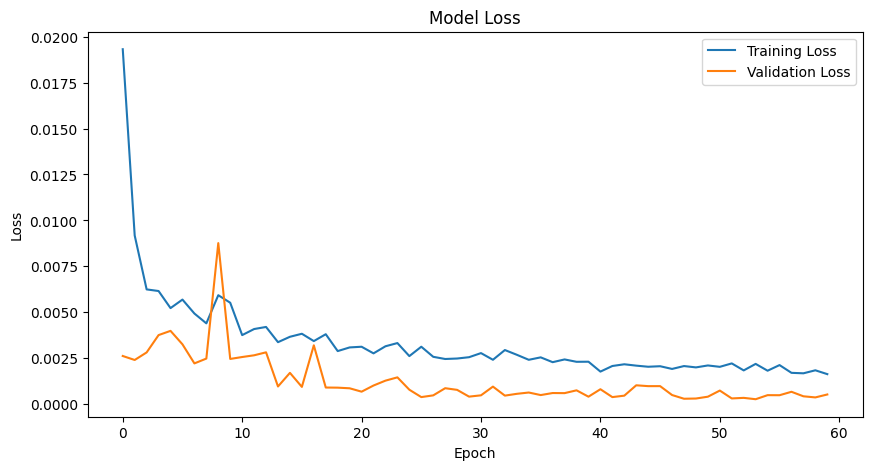

In [133]:
# Visualize loss
visualize_loss(history)

In [134]:
# Test the model
predicted_price, history = test_model(model, train, X_test, y_test)
print(predicted_price.shape)
print(predicted_price[0:10])
print(model.metrics_names)
print(history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(97, 1)
[[90.458405]
 [88.56127 ]
 [87.27137 ]
 [86.36061 ]
 [86.35789 ]
 [87.7513  ]
 [90.43277 ]
 [93.44152 ]
 [95.480194]
 [96.54806 ]]
['loss', 'mean_squared_error', 'root_mean_squared_error']
[0.0022526663276798945, 0.0022526663, 0.047462262]


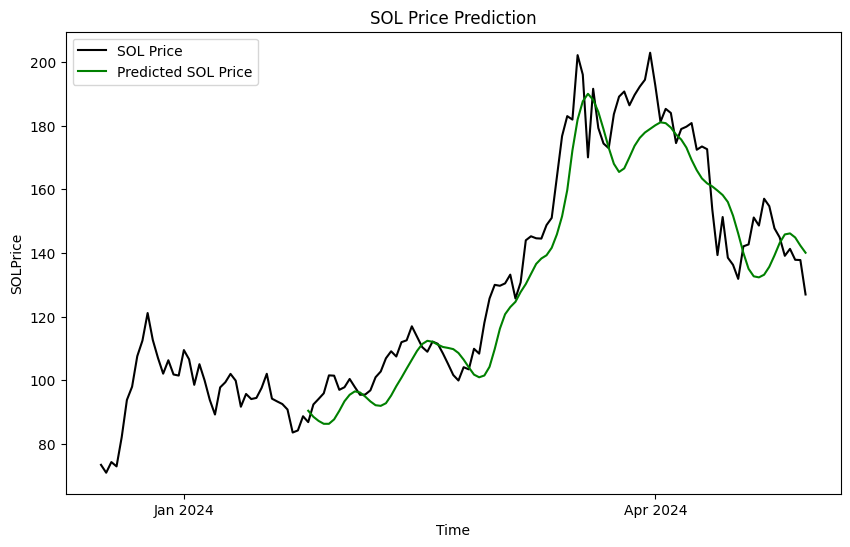

In [135]:
visualize_results(df, predicted_price, date_validation, coin, seq_length=seq_length)

In [136]:
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer(X_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [137]:
print(shap_values.shape)

(97, 40, 5, 1)


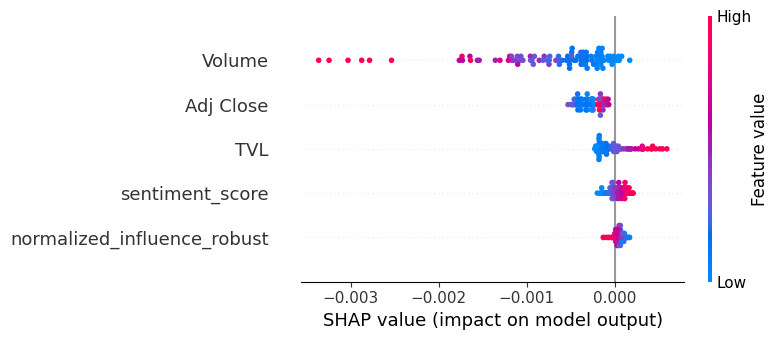

In [138]:
shap.summary_plot(shap_values[:,0,:,0], feature_names=features)

### Run the loop to test hyperparameters

In [152]:
def run_model_with_configs(coin, date_train, date_validation, features_list, seq_length_list, epochs_list):
  history_dict = {}
  df = read_data(coin)

  for features in features_list:
    for seq_length in seq_length_list:
      for epochs in epochs_list:
        train, validation, test = train_test_val(df, date_train, date_validation, features)
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled, validation_scaled, test_scaled = scale_features(scaler, train, validation, test)
        X_train, y_train = create_sequences(train_scaled, seq_length=seq_length)
        X_validation, y_validation = create_sequences(validation_scaled, seq_length=seq_length)
        X_test, y_test = create_sequences(test_scaled, seq_length=seq_length)
        y_train = np.reshape(y_train, (-1, 1))
        y_test = np.reshape(y_test, (-1, 1))
        y_validation = np.reshape(y_validation, (-1, 1))

        # Define, train and test the model
        model = define_model(optimizer, loss, seq_length=seq_length, num_parameters=len(features))
        train_model(model, X_train, y_train, X_validation, y_validation, epochs=epochs)
        predicted_price, history = test_model(model, train, X_test, y_test)

        # Store history with a key representing the configuration
        key = (tuple(features), seq_length, epochs)
        history_dict[key] = history

  return history_dict


features_list = [["Adj Close", "sentiment_score", "normalized_influence_robust", "Volume"], ["Adj Close", "sentiment_score", "normalized_influence_robust", "Volume"], ["Adj Close", "sentiment_score", "normalized_influence_minmax", "Volume"], ["Adj Close", "sentiment_score", "normalized_influence_standard", "Volume"]]
seq_length_list = [40]
epochs_list = [60]

history_dict = run_model_with_configs(coin, date_train, date_validation, features_list, seq_length_list, epochs_list)

print(history_dict)

     Adj Close  sentiment_score  normalized_influence_robust        Volume
0  7200.174316         0.548312                     3.988636  1.856566e+10
1  6985.470215         0.497812                     1.284091  2.080208e+10
2  7344.884277         0.125570                     2.972727  2.811148e+10
3  7410.656738         0.650860                     0.463636  1.844427e+10
4  7411.317383         0.357350                    -0.045455  1.972507e+10
Train on 1177 samples, validate on 144 samples
Epoch 1/60
1177/1177 [==============================] - ETA: 0s - loss: 0.0356 - mean_squared_error: 0.0356 - root_mean_squared_error: 0.1887

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1177/1177 [==============================] - 7s 6ms/sample - loss: 0.0356 - mean_squared_error: 0.0356 - root_mean_squared_error: 0.1887 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 2/60
1177/1177 [==============================] - 3s 2ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 3/60
1177/1177 [==============================] - 3s 2ms/sample - loss: 0.0069 - mean_squared_error: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 4/60
1177/1177 [==============================] - 3s 3ms/sample - loss: 0.0062 - mean_squared_error: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_root_mean_squared_error: 0.0339
Epoch 5/60
1177/1177 [==============================] - 4s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     Adj Close  sentiment_score  normalized_influence_robust        Volume
0  7200.174316         0.548312                     3.988636  1.856566e+10
1  6985.470215         0.497812                     1.284091  2.080208e+10
2  7344.884277         0.125570                     2.972727  2.811148e+10
3  7410.656738         0.650860                     0.463636  1.844427e+10
4  7411.317383         0.357350                    -0.045455  1.972507e+10
Train on 1177 samples, validate on 144 samples
Epoch 1/60
1177/1177 [==============================] - ETA: 0s - loss: 0.0360 - mean_squared_error: 0.0360 - root_mean_squared_error: 0.1898

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1177/1177 [==============================] - 6s 5ms/sample - loss: 0.0360 - mean_squared_error: 0.0360 - root_mean_squared_error: 0.1898 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 2/60
1177/1177 [==============================] - 3s 3ms/sample - loss: 0.0080 - mean_squared_error: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 3/60
1177/1177 [==============================] - 3s 2ms/sample - loss: 0.0068 - mean_squared_error: 0.0068 - root_mean_squared_error: 0.0828 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 4/60
1177/1177 [==============================] - 3s 2ms/sample - loss: 0.0063 - mean_squared_error: 0.0063 - root_mean_squared_error: 0.0797 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 5/60
1177/1177 [==============================] - 3s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     Adj Close  sentiment_score  normalized_influence_minmax        Volume
0  7200.174316         0.548312                     0.003044  1.856566e+10
1  6985.470215         0.497812                     0.001112  2.080208e+10
2  7344.884277         0.125570                     0.002318  2.811148e+10
3  7410.656738         0.650860                     0.000526  1.844427e+10
4  7411.317383         0.357350                     0.000162  1.972507e+10
Train on 1177 samples, validate on 144 samples
Epoch 1/60
1177/1177 [==============================] - ETA: 0s - loss: 0.0366 - mean_squared_error: 0.0366 - root_mean_squared_error: 0.1913

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1177/1177 [==============================] - 5s 5ms/sample - loss: 0.0366 - mean_squared_error: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 2/60
1177/1177 [==============================] - 3s 3ms/sample - loss: 0.0082 - mean_squared_error: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 3/60
1177/1177 [==============================] - 4s 3ms/sample - loss: 0.0077 - mean_squared_error: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 4/60
1177/1177 [==============================] - 3s 2ms/sample - loss: 0.0063 - mean_squared_error: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 5/60
1177/1177 [==============================] - 3s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     Adj Close  sentiment_score  normalized_influence_standard        Volume
0  7200.174316         0.548312                       0.139175  1.856566e+10
1  6985.470215         0.497812                      -0.082537  2.080208e+10
2  7344.884277         0.125570                       0.055893  2.811148e+10
3  7410.656738         0.650860                      -0.149796  1.844427e+10
4  7411.317383         0.357350                      -0.191530  1.972507e+10
Train on 1177 samples, validate on 144 samples
Epoch 1/60
1177/1177 [==============================] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336 - root_mean_squared_error: 0.1832

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1177/1177 [==============================] - 7s 6ms/sample - loss: 0.0336 - mean_squared_error: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2/60
1177/1177 [==============================] - 3s 2ms/sample - loss: 0.0080 - mean_squared_error: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 3/60
1177/1177 [==============================] - 3s 2ms/sample - loss: 0.0064 - mean_squared_error: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 4/60
1177/1177 [==============================] - 4s 3ms/sample - loss: 0.0063 - mean_squared_error: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 5/60
1177/1177 [==============================] - 3s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


{(('Adj Close', 'sentiment_score', 'normalized_influence_robust', 'Volume'), 40, 60): [0.002353782532736659, 0.0023537825, 0.048515797], (('Adj Close', 'sentiment_score', 'normalized_influence_minmax', 'Volume'), 40, 60): [0.001315802358857072, 0.0013158023, 0.03627399], (('Adj Close', 'sentiment_score', 'normalized_influence_standard', 'Volume'), 40, 60): [0.003317862273530757, 0.003317862, 0.057600886]}


In [153]:
history_dict

{(('Adj Close', 'sentiment_score', 'normalized_influence_robust', 'Volume'),
  40,
  60): [0.002353782532736659, 0.0023537825, 0.048515797],
 (('Adj Close', 'sentiment_score', 'normalized_influence_minmax', 'Volume'),
  40,
  60): [0.001315802358857072, 0.0013158023, 0.03627399],
 (('Adj Close', 'sentiment_score', 'normalized_influence_standard', 'Volume'),
  40,
  60): [0.003317862273530757, 0.003317862, 0.057600886]}